# Instructions
It can be useful to be able to classify new "test" documents using already classified "training" documents.  A common example is using a corpus of labeled spam and ham (non-spam) e-mails to predict whether or not a new document is spam.  Here is one example of such data:  UCI Machine Learning Repository: Spambase Data Set

For this project, you can either use the above dataset to predict the class of new documents (either withheld from the training dataset or from another source such as your own spam folder).

For more adventurous students, you are welcome (encouraged!) to come up a different set of documents (including scraped web pages!?) that have already been classified (e.g. tagged), then analyze these documents to predict how new documents should be classified.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Load Dataset

We decided to use the suggested UCI Machine Learning Repository: Spambase Data Set.



In [4]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

# fetch dataset
spambase = fetch_ucirepo(id=94)

# data (as pandas dataframes)
X = spambase.data.features
y = spambase.data.targets

# metadata
print(spambase.metadata)

# variable information
print(spambase.variables)


{'uci_id': 94, 'name': 'Spambase', 'repository_url': 'https://archive.ics.uci.edu/dataset/94/spambase', 'data_url': 'https://archive.ics.uci.edu/static/public/94/data.csv', 'abstract': 'Classifying Email as Spam or Non-Spam', 'area': 'Computer Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 4601, 'num_features': 57, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['Class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1999, 'last_updated': 'Mon Aug 28 2023', 'dataset_doi': '10.24432/C53G6X', 'creators': ['Mark Hopkins', 'Erik Reeber', 'George Forman', 'Jaap Suermondt'], 'intro_paper': None, 'additional_info': {'summary': 'The "spam" concept is diverse: advertisements for products/web sites, make money fast schemes, chain letters, pornography...\n\nThe classification task for this dataset is to determine whether a given email is spam or not.\n\t\nOur collecti

In [17]:
df = pd.concat([X,y], axis = 1)


In [18]:
df.describe()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,Class
count,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,...,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000
mean,0.104553,0.213015,0.280656,0.065425,0.312223,0.095901,0.114208,0.105295,0.090067,0.239413,...,0.038575,0.139030,0.016976,0.269071,0.075811,0.044238,5.191515,52.172789,283.289285,0.394045
std,0.305358,1.290575,0.504143,1.395151,0.672513,0.273824,0.391441,0.401071,0.278616,0.644755,...,0.243471,0.270355,0.109394,0.815672,0.245882,0.429342,31.729449,194.891310,606.347851,0.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.588000,6.000000,35.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.065000,0.000000,0.000000,0.000000,0.000000,2.276000,15.000000,95.000000,0.000000
75%,0.000000,0.000000,0.420000,0.000000,0.380000,0.000000,0.000000,0.000000,0.000000,0.160000,...,0.000000,0.188000,0.000000,0.315000,0.052000,0.000000,3.706000,43.000000,266.000000,1.000000
max,4.540000,14.280000,5.100000,42.810000,10.000000,5.880000,7.270000,11.110000,5.260000,18.180000,...,4.385000,9.752000,4.081000,32.478000,6.003000,19.829000,1102.500000,9989.000000,15841.000000,1.000000


# Preprocess Data

There is no missing data. But we want to scale the data to normalize the features in the dataset. This step is important for machine learning algorithms that are sensitive to the scale of the input features, such as K-Nearest Neightbors (KNN).

In [19]:
df.isnull().any()

word_freq_make                False
word_freq_address             False
word_freq_all                 False
word_freq_3d                  False
word_freq_our                 False
word_freq_over                False
word_freq_remove              False
word_freq_internet            False
word_freq_order               False
word_freq_mail                False
word_freq_receive             False
word_freq_will                False
word_freq_people              False
word_freq_report              False
word_freq_addresses           False
word_freq_free                False
word_freq_business            False
word_freq_email               False
word_freq_you                 False
word_freq_credit              False
word_freq_your                False
word_freq_font                False
word_freq_000                 False
word_freq_money               False
word_freq_hp                  False
word_freq_hpl                 False
word_freq_george              False
word_freq_650               

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test set

In [8]:
# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state=42, stratify=y)

# Train and Evaluate Models

We chose 4 classifer to train the dataset.


*   Naive Bayes: This classifier works well with high dimensional data. But it assume independence between the features.
*   K-Nearest Neighbors (KNN): It is useful for small dataset and non-linear data.
*   Decision Tree: This classifier is useful for both classification and regression and can handle non-linear relationships.
*   Random Forest: It is useful against overfitting and can handle non-linear relationships.



To determine the best classifier among the ones we've trained we can compare their performace based the following metrics: accuracy, precision, F1-score, and ROC-AUC score.

From the computed metrics, Random Forest is the best classifier among the ones we've tried since it has the highest accuracy, precision, F1-score, and ROC score.

In [14]:
models = {"Naive Bayes": GaussianNB(),
          "KNR": KNeighborsClassifier(),
          "Decision Tree": DecisionTreeClassifier(),
          "Random Forest": RandomForestClassifier()
          }


results = {}

# Train and evaluate models
for name, model in models.items():
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

  accuracy = accuracy_score(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, y_prob)
  confusion = confusion_matrix(y_test, y_pred)
  classification = classification_report(y_test, y_pred)

  results[name] = {
      "Accuracy Score": accuracy,
      "Confusion Matrix": confusion,
      "Classification Report": classification,
      "ROC Score": roc_auc,
      "y_prob": y_prob
  }

for name, metrics in results.items():
  print(f"\n{name}:\n")
  print(f"Accuracy Score:\n{metrics['Accuracy Score']}\n")
  print(f"Confusion Matrix:\n{metrics['Confusion Matrix']}\n")
  print(f"Classification Report:\n{metrics['Classification Report']}\n")



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
<ipython-input-14-7f7a0496ef70>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)



Naive Bayes:

Accuracy Score:
0.8327904451682954

Confusion Matrix:
[[419 139]
 [ 15 348]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.75      0.84       558
           1       0.71      0.96      0.82       363

    accuracy                           0.83       921
   macro avg       0.84      0.85      0.83       921
weighted avg       0.87      0.83      0.83       921



KNR:

Accuracy Score:
0.9055374592833876

Confusion Matrix:
[[518  40]
 [ 47 316]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       558
           1       0.89      0.87      0.88       363

    accuracy                           0.91       921
   macro avg       0.90      0.90      0.90       921
weighted avg       0.91      0.91      0.91       921



Decision Tree:

Accuracy Score:
0.9109663409337676

Confusion Matrix:
[[516  42]
 [ 40 323]]

Classification Report:
  

We can also visualize which classifer performed the best among trained by ploting ROC curve.

An ideal perfect classifier would have a TPR of 1 and an FPR of 0. Curves closer to the top-left corner indicate better performance

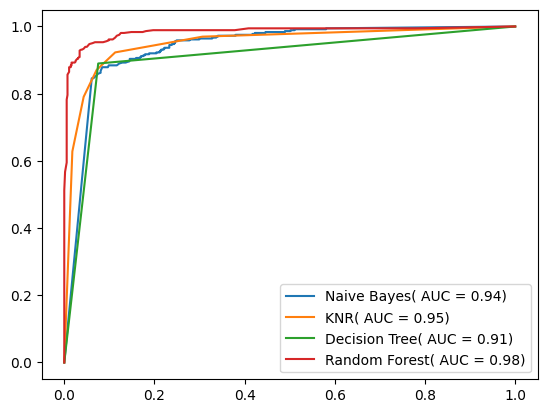

In [16]:
for name, metrics in results.items():
  fpr, tpr, _ = roc_curve(y_test, metrics['y_prob'])
  plt.plot(fpr, tpr, label = f'{name}( AUC = {metrics["ROC Score"]:.2f})')
  plt.legend(loc='lower right')

# Predict

Use the best classifier to predict a new data using a subset of the test data.

In [26]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

data = X_test[:5]
new_prediction = model.predict(data)
# print("Prediction:", new_prediction) #It prints 1's and 0's

predictions = np.where(new_prediction == 1 , 'spam', 'ham')
print("Prediction:", predictions)

<ipython-input-26-ac9412d14cab>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Prediction: ['spam' 'spam' 'ham' 'spam' 'ham']


# Conclusion

In this assignment, we did the following:


*   Load the dataset from the UCI Machine Learning Repository
*   Preprocess the data
*   Train and split the data
*   Train the model using various classifiers
*   Evaluate the model based on it performance by looking at the following metrics: accuracy, precision, F1-score, and ROC-AUC score
*   Use the trained model to classify new data

We chose 4 classifer to train the dataset: Naive Bayes, K-Nearest Neighbors (KNN), Decision Tree, and Random Forest

To determine the best classifier among the ones we've trained we can compare their performace based the following metrics: accuracy, precision, F1-score, and ROC-AUC score.

From the computed metrics, Random Forest is the best classifier among the ones we've tried since it has the highest accuracy, precision, F1-score, and ROC score.






